# AWS Data Ingestion Cost Analysis

This notebook presents a cost analysis of different AWS services for data ingestion, including Kinesis Firehose, Kinesis Data Streams, IoT MQTT, and S3 PutObjects.

The cost analysis is based on a scenario where data is being sent at a rate of 100 messages per second from each of 40 devices, for a total of 4000 messages per second. The costs are calculated over a period of up to 720 hours (30 days).

The costs for Kinesis Firehose and IoT MQTT are based on the volume of raw data, Kinesis Data Streams is similar but does ingestion in batches. For S3 PutObjects, the data is assumed to be compressed and batched into fewer PUT requests, which significantly reduces the cost - atleast for larger batch sizes.

The results are presented in two graphs:
- The first graph shows the costs as the volume of data increases, for different batch sizes for S3 PutObjects (from 1 to 100,000 records per PUT request), compared to Kinesis Firehose/Data Streams and IoT MQTT.
- The second graph shows the costs for larger batch sizes (from 1000 to 100,000 records per PUT request), making the comparison between S3 PutObjects and Kinesis Firehose/Data Streams more clear.

The batch size is the number of records included in each PUT request. The cost of S3 PutObjects decreases as the batch size increases because the cost per PUT request is reduced.


In [ ]:
%pip install matplotlib numpy

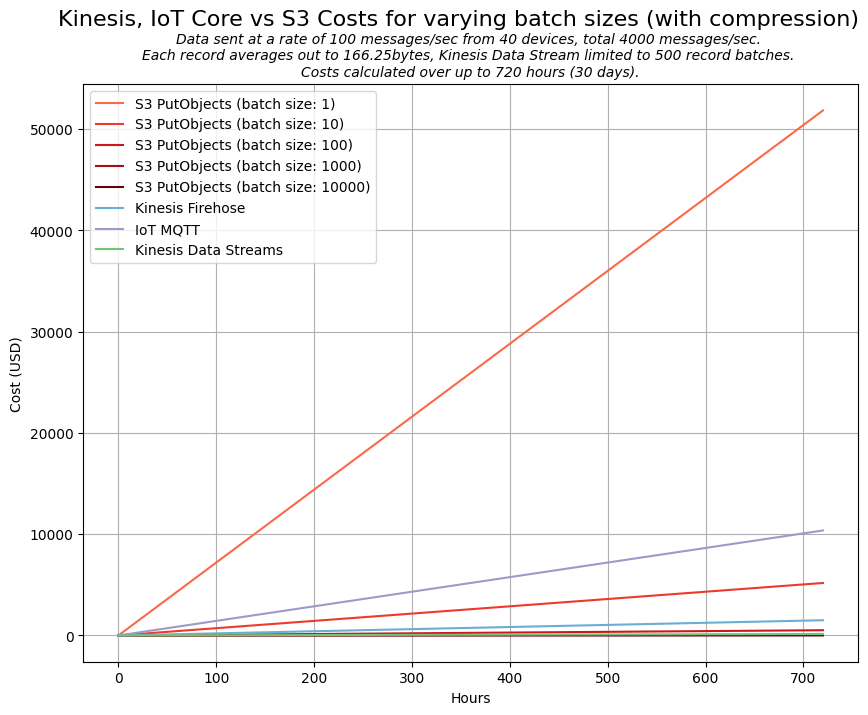

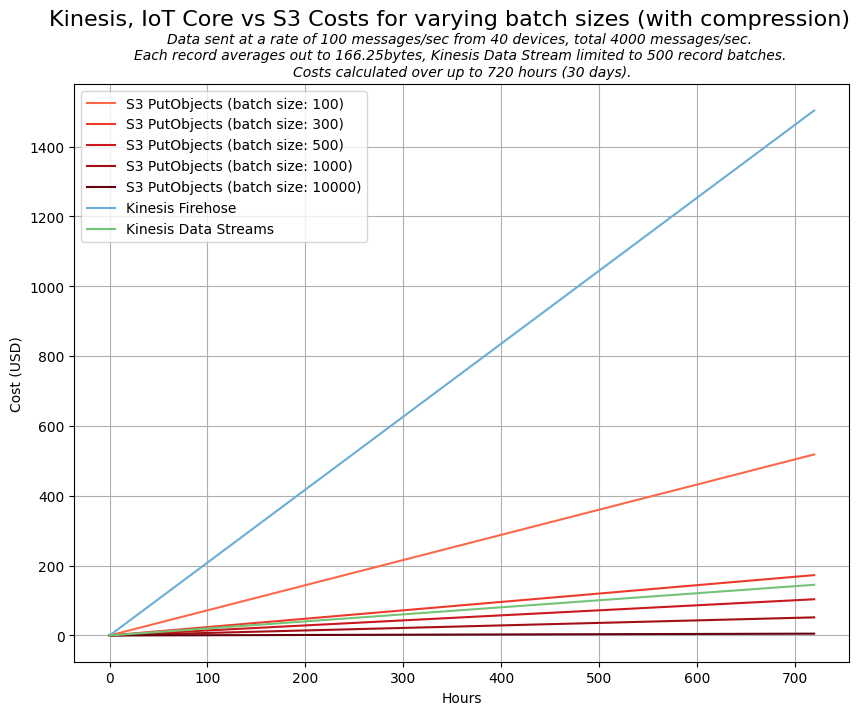

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
AWS_COSTS = {
    "firehose_cost_per_gb": 0.029,  # dollars
    "mqtt_cost_per_message": 1 / 1e6,  # dollars
    "s3_cost_per_gb": 0.023,  # dollars
    "s3_cost_per_put": 0.005 / 1e3  # dollars
}

KINESIS_COSTS = {
    "kinesis_data_streams_cost_per_put_payload_unit": 0.014 / 1e6,  # dollars
    "put_payload_unit_size_kb": 25  # kilobytes
}

DATA_CONSTANTS = {
    "records_per_second": 100 * 40,  # records
    "record_size_bytes": 166.25,  # bytes
    "hours": np.linspace(0, 720, num=100)  # up to 30 days
}

# Calculate the compression ratio from the provided file
raw_data_size = DATA_CONSTANTS["record_size_bytes"] * DATA_CONSTANTS["records_per_second"] * 3600  # Size of an hour's worth of raw data in bytes
compressed_data_size = 3129  # Size of the compressed data file in bytes
compression_ratio = compressed_data_size / raw_data_size


def calculate_records_and_raw_data(hours):
    seconds = hours * 3600  # convert hours to seconds
    records = DATA_CONSTANTS["records_per_second"] * seconds  # total number of records
    raw_data_gb = records * DATA_CONSTANTS["record_size_bytes"] / 1e9  # total raw data volume in GB
    return records, raw_data_gb


def calculate_costs_firehose_mqtt(hours):
    records, raw_data_gb = calculate_records_and_raw_data(hours)
    
    # total raw data volume in GB accounting for Firehose's 5KB rounding
    rounded_record_size_bytes = max(DATA_CONSTANTS["record_size_bytes"], 5 * 1e3)
    raw_data_gb = records * rounded_record_size_bytes / 1e9

    # Calculate costs for each service
    firehose_cost = raw_data_gb * AWS_COSTS["firehose_cost_per_gb"]
    mqtt_cost = records * AWS_COSTS["mqtt_cost_per_message"]

    return firehose_cost, mqtt_cost


def calculate_s3_cost_with_compression(batch_size, hours):
    records, raw_data_gb = calculate_records_and_raw_data(hours)
    compressed_data_gb = raw_data_gb * compression_ratio  # total compressed data volume in GB

    # Calculate S3 cost for the given batch size
    puts = records / batch_size  # total number of PUT requests
    s3_cost = puts * AWS_COSTS["s3_cost_per_put"] + compressed_data_gb * AWS_COSTS["s3_cost_per_gb"]

    return s3_cost


def calculate_costs_kinesis_data_streams(hours):
    records, _ = calculate_records_and_raw_data(hours)

    # total raw data volume in KB accounting for Kinesis Data Stream's 25KB rounding
    rounded_record_size_kb = np.ceil(max(DATA_CONSTANTS["record_size_bytes"] / 1e3, KINESIS_COSTS["put_payload_unit_size_kb"]))
    put_payload_units = records * rounded_record_size_kb / KINESIS_COSTS["put_payload_unit_size_kb"]

    # Calculate costs for Kinesis Data Streams
    kinesis_data_streams_cost = put_payload_units * KINESIS_COSTS["kinesis_data_streams_cost_per_put_payload_unit"]

    return kinesis_data_streams_cost


def plot_costs_vs_hours(batch_sizes, hours, colors, plot_mqtt=True):

    # Plot the costs vs data volume for each batch size
    plt.figure(figsize=(10, 7.5))
    for i, batch_size in enumerate(batch_sizes):
        s3_costs = np.vectorize(lambda hours: calculate_s3_cost_with_compression(batch_size, hours))(hours)
        plt.plot(hours, s3_costs, label=f'S3 PutObjects (batch size: {batch_size})', color=colors[i])
    
    # Plot the costs vs data volume for Kinesis Firehose and Kinesis Data Streams
    firehose_cost, mqtt_cost = np.vectorize(calculate_costs_firehose_mqtt)(hours)
    plt.plot(hours, firehose_cost, label='Kinesis Firehose', color=plt.cm.Blues(0.5))
    if plot_mqtt:
        plt.plot(hours, mqtt_cost, label='IoT MQTT', color=plt.cm.Purples(0.5))
    kinesis_data_streams_cost = np.vectorize(calculate_costs_kinesis_data_streams)(hours)
    plt.plot(hours, kinesis_data_streams_cost, label='Kinesis Data Streams', color=plt.cm.Greens(0.5))

    plt.xlabel('Hours')
    plt.ylabel('Cost (USD)')
    plt.suptitle('Kinesis, IoT Core vs S3 Costs for varying batch sizes (with compression)', fontsize=16)
    plt.title('Data sent at a rate of 100 messages/sec from 40 devices, total 4000 messages/sec. \nEach record averages out to 166.25bytes, Kinesis Data Stream limited to 500 record batches. \nCosts calculated over up to 720 hours (30 days).', fontsize=10, fontstyle='italic')
    plt.legend()
    plt.grid(True)
    plt.show()

# Define batch sizes to compare
compare_batch_sizes = [1, 10, 100, 1000, 10000]

# Define a color map for the lines
colors = plt.cm.Reds(np.linspace(0.5, 1, len(compare_batch_sizes)))

# Plot the costs for the first batch sizes
plot_costs_vs_hours(compare_batch_sizes, DATA_CONSTANTS["hours"], colors)

# Define batch sizes to compare
compare_batch_sizes = [100, 300, 500, 1000, 10000]

# Plot the costs for the second batch sizes without MQTT
plot_costs_vs_hours(compare_batch_sizes, DATA_CONSTANTS["hours"], colors, plot_mqtt=False)